<a href="https://colab.research.google.com/github/Raafat-Nagy/Deep-Learning-Projects/blob/main/Brain_Tumor_MRI/Brain_Tumor_MRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Tumor MRI

**Datasets URL:**
https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset

## Import Libraries


In [3]:
import tensorflow as tf

print(tf.__version__)

2.18.0


In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")

## Import Dataset and Preprocessing


In [5]:
main_dir = "/kaggle/input/brain-tumor-mri-dataset"
os.listdir(main_dir)

['Training', 'Testing']

In [6]:
train_dir = os.path.join(main_dir,"Training")
test_dir = os.path.join(main_dir,"Training")

In [7]:
summary = []

for root, dirs, files in os.walk(main_dir):
    if root and not dirs:
        split_path = root.split(os.sep)[-2:]
        if len(split_path) == 2:
            split, cls = split_path
            summary.append({"Split": split, "Class": cls, "Count": len(files)})

# summary

In [8]:
df = pd.DataFrame(summary)
data_summary = df.pivot(index="Class", columns="Split", values="Count")
data_summary

Split,Testing,Training
Class,,
glioma,300,1321
meningioma,306,1339
notumor,405,1595
pituitary,300,1457


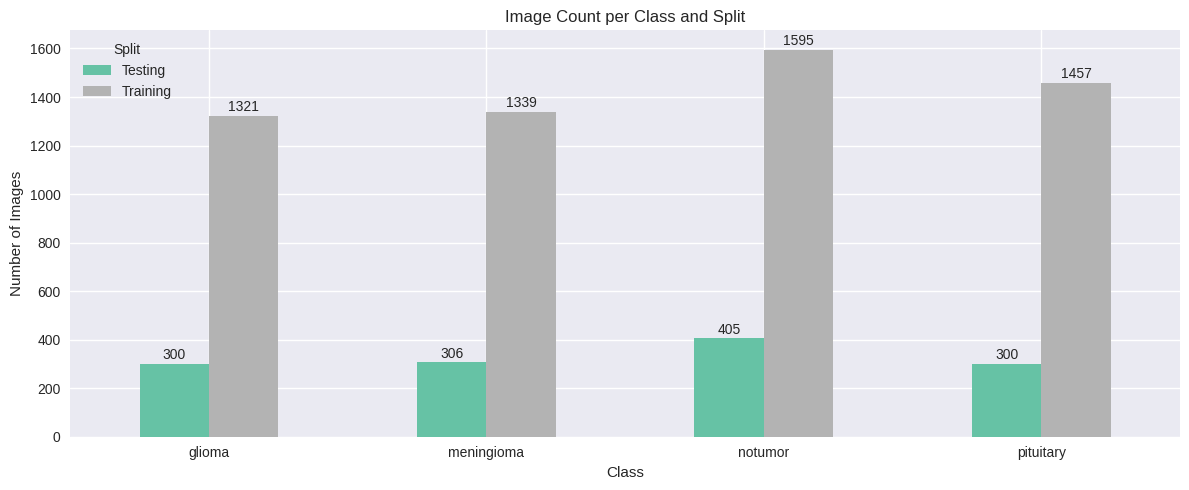

In [ ]:
ax = data_summary.plot(kind="bar", figsize=(12, 5), colormap='Set2')
plt.title("Image Count per Class and Split")
plt.ylabel("Number of Images")
plt.xticks(rotation=0)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 20, str(int(height)), ha="center")

plt.tight_layout()
plt.show()

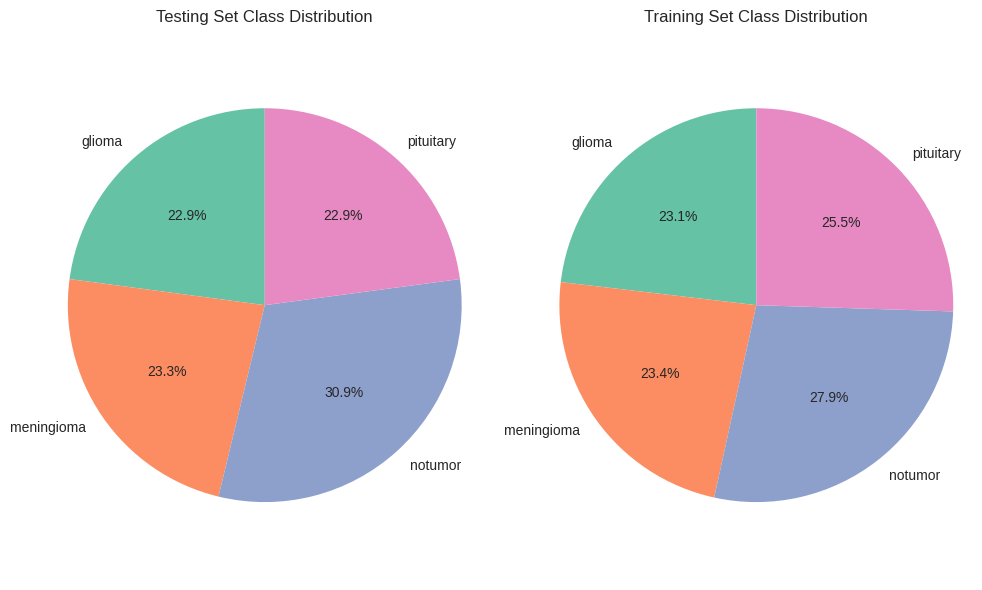

In [ ]:
def plot_class_distribution_pie(df, figsize=None):
    splits = df.columns

    plt.figure(figsize=figsize or (len(splits)*5, 6))

    for i, split in enumerate(splits, 1):
        plt.subplot(1, len(splits), i)
        counts = df[split]

        plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Set2.colors)
        plt.title(f"{split.capitalize()} Set Class Distribution")
        plt.axis('equal')

    plt.tight_layout()
    plt.show()

plot_class_distribution_pie(data_summary)

## Load Data


In [61]:
print(f"Train Dir: '{train_dir}'")
print(f"Test Dir: '{test_dir}'")

Train Dir: '/kaggle/input/brain-tumor-mri-dataset/Training'
Test Dir: '/kaggle/input/brain-tumor-mri-dataset/Training'


In [42]:
# Define parameters
IMG_SIZE = (300, 300)
BATCH_SIZE = 128
INPUT_SHAPE = (*IMG_SIZE, 3)
SEED = 42

# Load datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset="training"
    )


val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False,
    seed=SEED,
    validation_split=0.2,
    subset="validation"
    )


test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False,
    seed=SEED
    )

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 5712 files belonging to 4 classes.


In [44]:
class_names = train_ds.class_names
output_shape = len(class_names)

print(class_names)
print(output_shape)

['glioma', 'meningioma', 'notumor', 'pituitary']
4


## Visualize the data

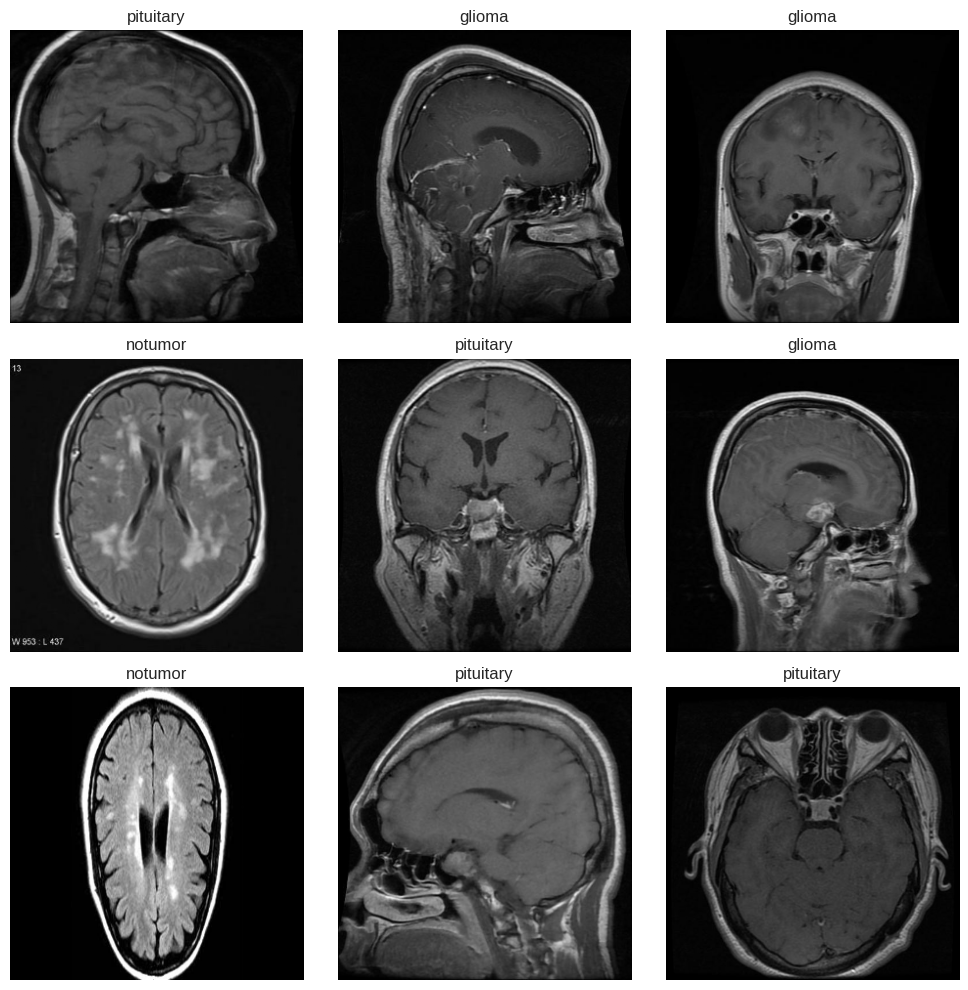

In [45]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i] / 255)
    plt.title(class_names[labels[i]])
    plt.axis("off")

  plt.tight_layout()
  plt.show()

In [46]:
for image_batch, labels_batch in train_ds.take(1):
  print(image_batch.shape)
  print(labels_batch.shape)

(128, 300, 300, 3)
(128,)


## Data Augmentation


In [50]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.15),
    tf.keras.layers.RandomZoom(0.15),
    tf.keras.layers.RandomHeight(0.15),
    tf.keras.layers.RandomWidth(0.15),
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

## Plot Augmented Image

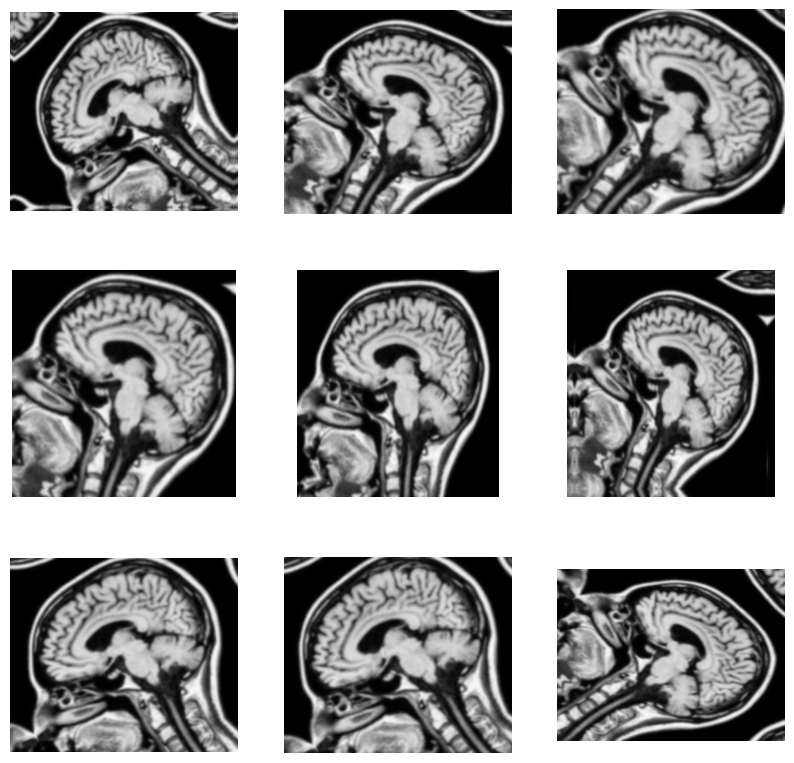

In [51]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Build the Model

### Load Pre-trained Base Model ResNet50V2

In [ ]:
from tensorflow.keras.applications import ResNet50V2

base_model = ResNet50V2(include_top=False, weights='imagenet')

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
# base_model.summary()

### Fine-Tuning


In [28]:
print("Number of layers in the base model:", len(base_model.layers))

Number of layers in the base model: 190


In [63]:
NUM_UNFROZEN_LAYERS = 5  # Number of layers to fine-tune

base_model.trainable = True
for layer in base_model.layers[:-NUM_UNFROZEN_LAYERS]:
    layer.trainable = False

### Build Full Model

In [64]:
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model


def build_full_model(base_model, input_shape, output_shape):
    inputs = Input(shape=input_shape)

    x = preprocess_input(inputs)
    x = base_model(x)

    # Classification head
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.5)(x)
    outputs = Dense(output_shape, activation="softmax")(x)

    model = Model(inputs, outputs)
    return model

model = build_full_model(base_model, INPUT_SHAPE, output_shape)

In [65]:
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 10, 10, 2048)   │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,827,588 (90.90 MB)

 Trainable params: 1,317,508 (5.03 MB)

 Non-trainable params: 22,510,080 (85.87 MB)

---

## Compile the Model


In [ ]:
learning_rate=1e-4
optimizer=tf.keras.optimizers.Adam(learning_rate)
loss=tf.keras.losses.SparseCategoricalCrossentropy()
metrics=["accuracy"]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

## Train the Model


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.8,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

callbacks = [early_stopping, reduce_lr]

In [ ]:
epochs = 25

history = model.fit(
    train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks
)

Epoch 1/25


I0000 00:00:1746733639.698312      65 service.cc:148] XLA service 0x250d04f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746733639.699279      65 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746733641.060921      65 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746733656.866560      65 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


35/36 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.4909 - loss: 1.1627

E0000 00:00:1746734050.367171      66 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746734050.609957      66 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.4948 - loss: 1.1562 

E0000 00:00:1746734069.254627      66 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746734069.503320      66 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


36/36 ━━━━━━━━━━━━━━━━━━━━ 451s 12s/step - accuracy: 0.4986 - loss: 1.1500 - val_accuracy: 0.6970 - val_loss: 0.8360 - learning_rate: 1.0000e-04
Epoch 2/25
35/36 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.7960 - loss: 0.5818 

E0000 00:00:1746734383.780283      66 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746734384.022964      66 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


36/36 ━━━━━━━━━━━━━━━━━━━━ 316s 9s/step - accuracy: 0.7972 - loss: 0.5785 - val_accuracy: 0.8082 - val_loss: 0.5824 - learning_rate: 1.0000e-04
Epoch 3/25
35/36 ━━━━━━━━━━━━━━━━━━━━ 6s 7s/step - accuracy: 0.8618 - loss: 0.3995 

E0000 00:00:1746734641.183452      64 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746734641.425494      64 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


36/36 ━━━━━━━━━━━━━━━━━━━━ 255s 7s/step - accuracy: 0.8619 - loss: 0.3991 - val_accuracy: 0.8205 - val_loss: 0.5815 - learning_rate: 1.0000e-04
Epoch 4/25
35/36 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.8658 - loss: 0.3692 

E0000 00:00:1746734884.027899      65 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746734884.270476      65 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


36/36 ━━━━━━━━━━━━━━━━━━━━ 245s 7s/step - accuracy: 0.8665 - loss: 0.3685 - val_accuracy: 0.9553 - val_loss: 0.2429 - learning_rate: 1.0000e-04
Epoch 5/25
35/36 ━━━━━━━━━━━━━━━━━━━━ 5s 6s/step - accuracy: 0.8904 - loss: 0.3127 

E0000 00:00:1746735093.789252      64 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746735094.031147      64 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


36/36 ━━━━━━━━━━━━━━━━━━━━ 209s 6s/step - accuracy: 0.8905 - loss: 0.3126 - val_accuracy: 0.9466 - val_loss: 0.2421 - learning_rate: 1.0000e-04
Epoch 6/25
35/36 ━━━━━━━━━━━━━━━━━━━━ 5s 6s/step - accuracy: 0.8986 - loss: 0.2848 

E0000 00:00:1746735302.066717      65 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746735302.308365      65 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


36/36 ━━━━━━━━━━━━━━━━━━━━ 206s 6s/step - accuracy: 0.8989 - loss: 0.2844 - val_accuracy: 0.9536 - val_loss: 0.2118 - learning_rate: 1.0000e-04
Epoch 7/25
35/36 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.9047 - loss: 0.2598 

E0000 00:00:1746735533.892416      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746735534.134089      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


36/36 ━━━━━━━━━━━━━━━━━━━━ 230s 6s/step - accuracy: 0.9051 - loss: 0.2594 - val_accuracy: 0.9623 - val_loss: 0.1917 - learning_rate: 1.0000e-04
Epoch 8/25
35/36 ━━━━━━━━━━━━━━━━━━━━ 4s 5s/step - accuracy: 0.9155 - loss: 0.2406

E0000 00:00:1746735716.919982      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746735717.161609      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


36/36 ━━━━━━━━━━━━━━━━━━━━ 185s 5s/step - accuracy: 0.9156 - loss: 0.2403 - val_accuracy: 0.9694 - val_loss: 0.1516 - learning_rate: 1.0000e-04
Epoch 9/25
35/36 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.9173 - loss: 0.2415 

E0000 00:00:1746735912.014279      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746735912.256055      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


36/36 ━━━━━━━━━━━━━━━━━━━━ 193s 5s/step - accuracy: 0.9177 - loss: 0.2403 - val_accuracy: 0.9799 - val_loss: 0.1187 - learning_rate: 1.0000e-04
Epoch 10/25
35/36 ━━━━━━━━━━━━━━━━━━━━ 4s 5s/step - accuracy: 0.9291 - loss: 0.1965

E0000 00:00:1746736093.748835      64 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746736093.990679      64 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


36/36 ━━━━━━━━━━━━━━━━━━━━ 182s 5s/step - accuracy: 0.9290 - loss: 0.1968 - val_accuracy: 0.9877 - val_loss: 0.0839 - learning_rate: 1.0000e-04
Epoch 11/25
35/36 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.9331 - loss: 0.1984 

E0000 00:00:1746736295.821022      65 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746736296.062648      65 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


36/36 ━━━━━━━━━━━━━━━━━━━━ 202s 5s/step - accuracy: 0.9333 - loss: 0.1980 - val_accuracy: 0.9851 - val_loss: 0.0873 - learning_rate: 1.0000e-04
Epoch 12/25
35/36 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.9338 - loss: 0.1895 

E0000 00:00:1746736483.015549      66 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746736483.257448      66 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


36/36 ━━━━━━━━━━━━━━━━━━━━ 185s 5s/step - accuracy: 0.9338 - loss: 0.1895 - val_accuracy: 0.9781 - val_loss: 0.1149 - learning_rate: 1.0000e-04
Epoch 13/25
35/36 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.9362 - loss: 0.1829

E0000 00:00:1746736647.464393      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746736647.706158      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9362 - loss: 0.1828
Epoch 13: ReduceLROnPlateau reducing learning rate to 7.999999797903001e-05.
36/36 ━━━━━━━━━━━━━━━━━━━━ 164s 5s/step - accuracy: 0.9362 - loss: 0.1827 - val_accuracy: 0.9606 - val_loss: 0.1493 - learning_rate: 1.0000e-04
Epoch 14/25
35/36 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.9459 - loss: 0.1718

E0000 00:00:1746736805.428364      64 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746736805.670292      64 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


36/36 ━━━━━━━━━━━━━━━━━━━━ 158s 4s/step - accuracy: 0.9457 - loss: 0.1717 - val_accuracy: 0.9764 - val_loss: 0.1047 - learning_rate: 8.0000e-05
Epoch 15/25
35/36 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.9493 - loss: 0.1557

E0000 00:00:1746736970.243672      65 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746736970.485708      65 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


36/36 ━━━━━━━━━━━━━━━━━━━━ 165s 5s/step - accuracy: 0.9492 - loss: 0.1556 - val_accuracy: 0.9562 - val_loss: 0.1515 - learning_rate: 8.0000e-05
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 10.


## Plot Training History


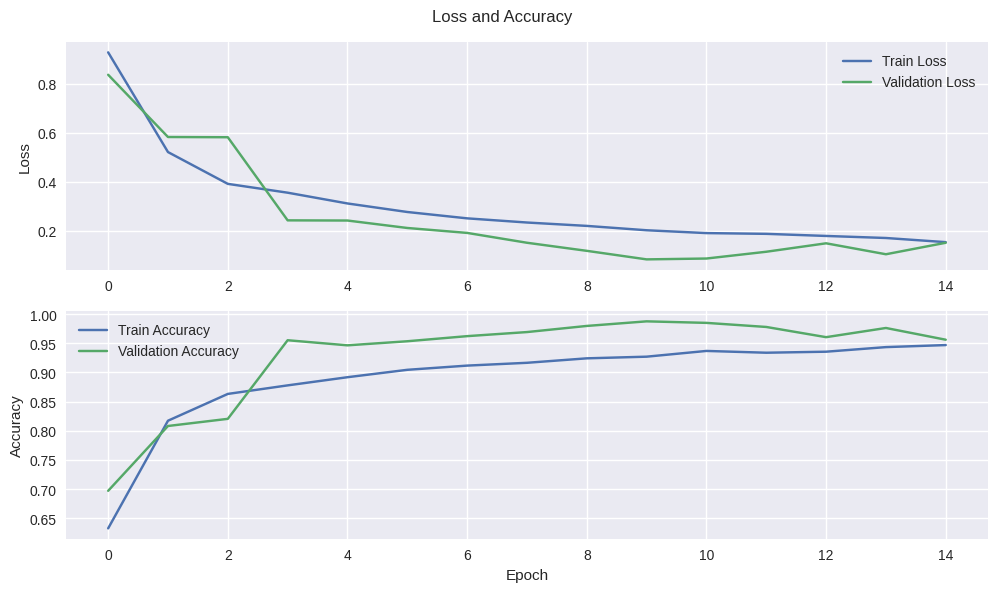

In [ ]:
plt.figure(figsize=(10, 6))
plt.suptitle("Loss and Accuracy")

plt.subplot(2, 1, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.ylabel("Loss")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.ylabel("Accuracy")
plt.legend()

plt.xlabel("Epoch")
plt.tight_layout()
plt.show()

## Evaluate the Model


In [56]:
loss, accuracy = model.evaluate(val_ds)
print(f"Val Loss: {loss:.4f}")
print(f"Val Accuracy: {accuracy * 100:.2f}%")

9/9 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - accuracy: 0.9892 - loss: 0.0842
Val Loss: 0.0839
Val Accuracy: 98.77%


In [ ]:
loss, accuracy = model.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 444ms/step - accuracy: 0.9176 - loss: 0.2118
Test Loss: 0.1872
Test Accuracy: 93.26%


## Get true and predicted labels


In [ ]:
true_labels = np.concatenate([labels.numpy() for _, labels in test_ds])

true_labels, true_labels.shape

(array([0, 0, 0, ..., 3, 3, 3], dtype=int32), (5712,))

In [ ]:
predictions = model.predict(test_ds)
pred_labels = np.argmax(predictions, axis=1)

pred_labels, pred_labels.shape

45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 299ms/step


(array([0, 0, 0, ..., 3, 3, 3]), (5712,))

## Classification Report


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(true_labels, pred_labels, target_names=class_names))

              precision    recall  f1-score   support

      glioma       0.92      0.93      0.93      1321
  meningioma       0.90      0.83      0.87      1339
     notumor       0.98      0.97      0.97      1595
   pituitary       0.92      0.98      0.95      1457

    accuracy                           0.93      5712
   macro avg       0.93      0.93      0.93      5712
weighted avg       0.93      0.93      0.93      5712



## Confusion Matrix


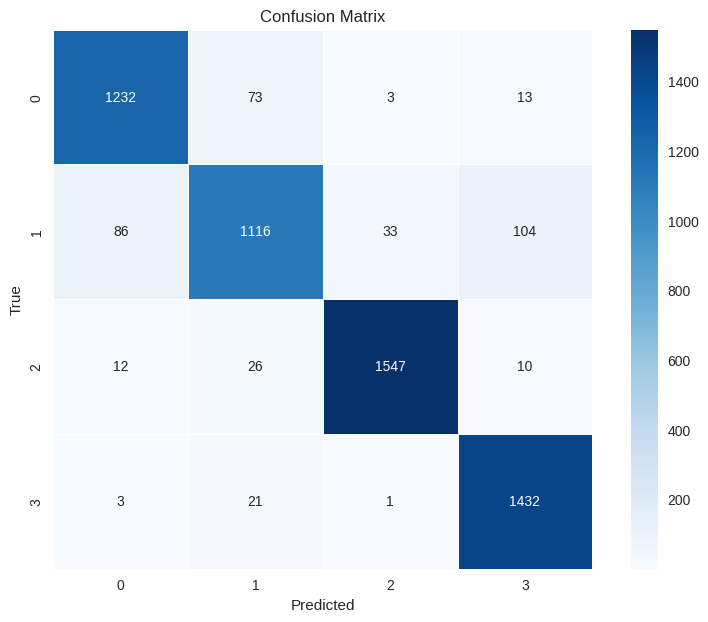

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


def plot_confusion_matrix(true_labels, pred_labels):
    cm = confusion_matrix(true_labels, pred_labels)

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5, square=True)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


plot_confusion_matrix(true_labels, pred_labels)

## Visualize Predictions


4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step


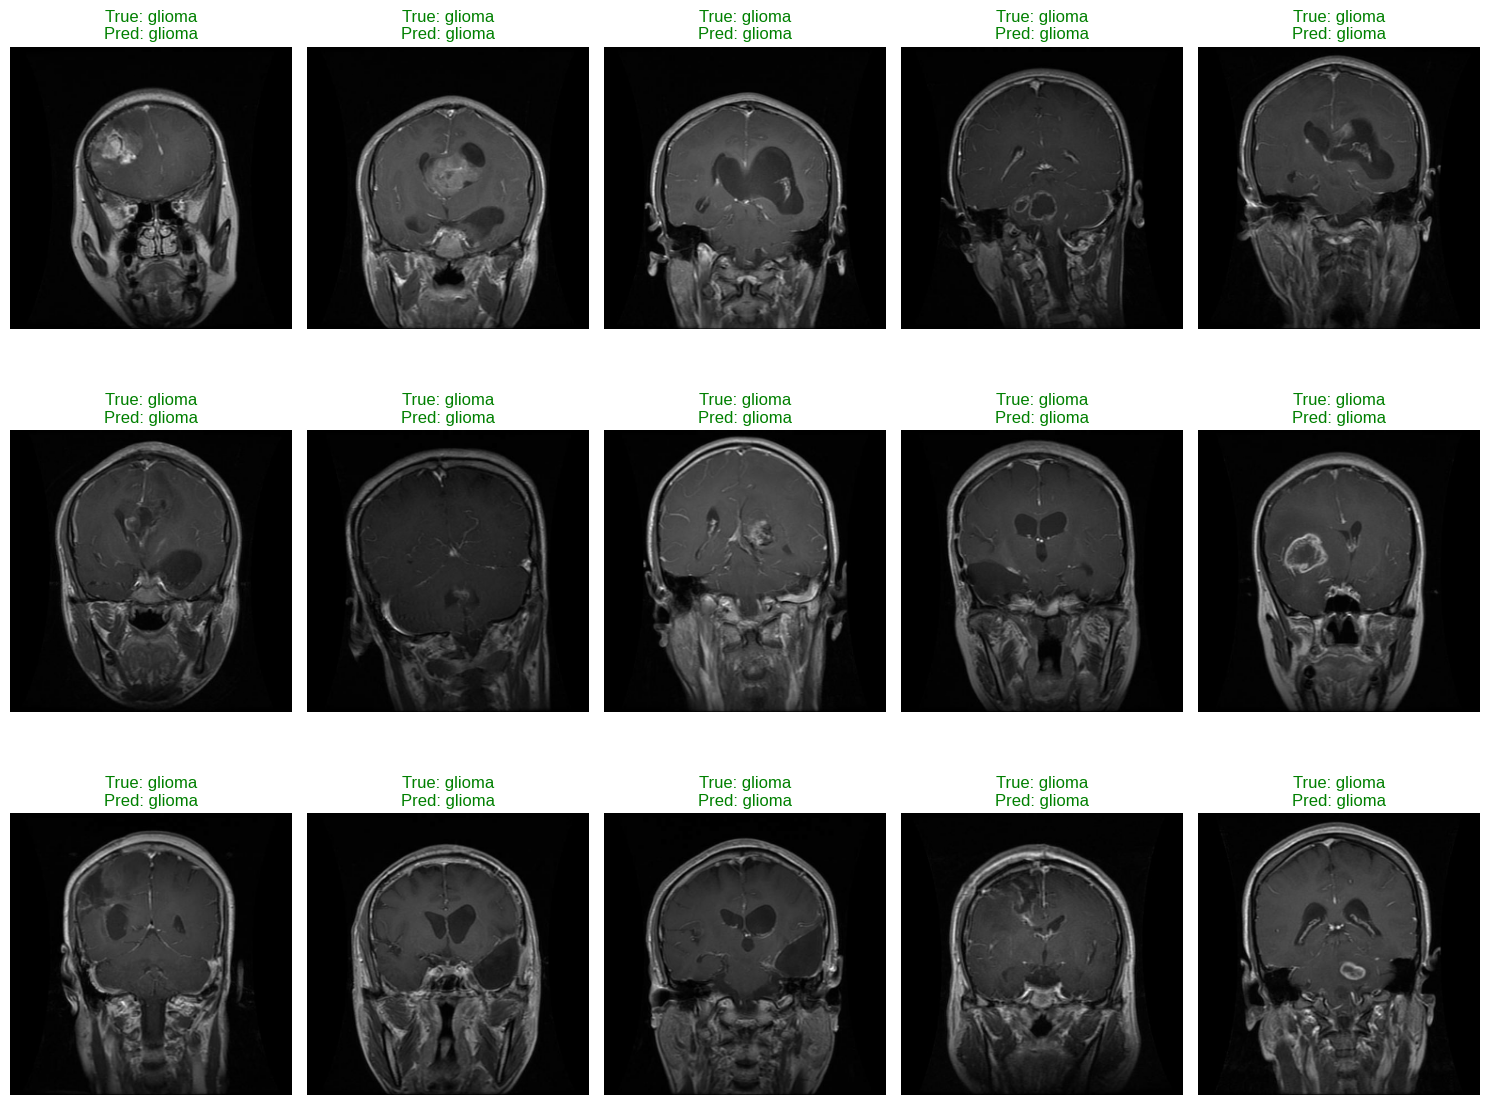

In [ ]:
for images, labels in test_ds.take(1):
    preds = model.predict(images)
    pred_labels = np.argmax(preds, axis=1)

    plt.figure(figsize=(15, 12))

    for i in range(15):
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(images[i] / 255)
        true_label = class_names[labels[i]]
        predicted_label = class_names[pred_labels[i]]
        color = "green" if true_label == predicted_label else "red"

        plt.title(f"True: {true_label}\nPred: {predicted_label}", color=color)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

## Save the Model

In [ ]:
model.save("Brain_Tumor_MRI_Model.keras")
print("Model Saved Successfully!")

Model Saved Successfully!


---

## Download Trained Model From Kaggle

In [59]:
!kaggle kernels output raafatnagy/brain-tumor-mri -p /content

Output file downloaded to /content/Brain_Tumor_MRI_Model.keras
Kernel log downloaded to /content/brain-tumor-mri.log 
